In [22]:
"""
CheXNet applied to chest X-ray images classifying pneumonia vs non-pneumonia.
"""

import tensorflow.python.keras.backend as K
import numpy as np
import tensorflow as tf
from loss import WeightedCrossEntropyBinaryLoss
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
from keras.layers import Input, Dense
from keras.models import Model
import prepare_data
import os

In [37]:
# input_path = '../input/chest_xray/chest_xray/'
input_path = 'C:/Users/marta/OneDrive/Desktop/Osnabruck/ImplementingANNswithTensorFlow/FinalProject/chest_xray/'

# Checkpoint file path
checkpoint_filepath = './Checkpoint/weights.hdf5' 

# Train data path
train_data_path = input_path+'train'

# Val data path
val_data_path = input_path+'test'

# Hyperparameters
img_dims = 224
n_epochs = 10
batch_size = 16 # since it's a binary classification task
output_size = 1

# Getting the data
train_gen, test_gen, test_data, test_labels = prepare_data.prepare_data(img_dims, batch_size)

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [27]:
class CheXNet(tf.keras.Model):
  """
  The model using modified DenseNet121.
  """

  def __init__ (self):
    """
    The constructor initiates the layers and their activation functions....
    """
    super().__init__()

    # Following will be set by get_data_stats() based on the dataset
    self.zero_weight = None
    self.one_weight = None
    self.train_steps = None
    self.val_steps = None

    # get_model() will initialize this to DenseNet121 model
    self.model = None
  
  def get_data_stats(self, train_data_path, val_data_path):
    """
    Computes normal Vs Pneumonia class distribution.
    :param train_data_path: path to training data.
    :param val_data_path: path to validation data.
    """

    # Count images in each class
    n_normal = len(os.listdir(train_data_path + '/NORMAL'))
    n_infect = len(os.listdir(train_data_path + '/PNEUMONIA'))

    # compute class distribution
    self.one_weight = float(n_normal)/(n_normal+n_infect)
    self.zero_weight = float(n_infect)/(n_normal+n_infect)

    # For convenience at train time, compute number of steps required to complete an epoch
    n_normal_val = len(os.listdir(val_data_path + '/NORMAL'))
    n_infect_val = len(os.listdir(val_data_path + '/PNEUMONIA'))

    self.train_steps = ((n_normal+n_infect) // batch_size) + 1
    self.val_steps = ((n_normal_val+n_infect_val) // batch_size) + 1  


  def get_model(self):
    # DenseNet121 expects number of channels to be 3
    input = Input(shape=(img_dims, img_dims, 3), batch_size=batch_size)

    # using pretrained DenseNet121 as the foundation of the model
    base_model = tf.keras.applications.densenet.DenseNet121(include_top=False, weights='imagenet',
                                                            input_shape=(img_dims, img_dims, 3), pooling='avg')
    
    # Add custom output layers
    x = base_model.output
    x = tf.keras.layers.Dense(output_size, activation='sigmoid')(x)

    self.model = tf.keras.models.Model(inputs=base_model.input, outputs=x)

    # Using weighted binary loss has been suggested in the paper
    loss = WeightedCrossEntropyBinaryLoss(self.zero_weight, self.one_weight)

    # Compile the model
    self.model.compile(optimizer=tf.keras.optimizers.Adam(beta_1=0.9, beta_2=0.999),
                       loss=loss.weighted_binary_crossentropy, metrics=['accuracy'])
    
    return self.model

# Instantiate the CheXNet model
chexnet = CheXNet()

# Compute normal Vs Pneumonia class distribution
chexnet.get_data_stats(train_data_path, val_data_path)

# Create and compile the DenseNet121 model
model = chexnet.get_model()

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=1, verbose=1)
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.1, patience=1, mode='min')
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    mode='min',
    save_best_only=True)

In [28]:
# #Fitting the model
history = model.fit(
    train_gen, epochs=n_epochs, validation_data=test_gen,
    callbacks=[reduce_lr, model_checkpoint])


Epoch 1/10
326/326 [==============================] - 895s 3s/step - loss: 0.0948 - accuracy: 0.9016 - val_loss: 0.3002 - val_accuracy: 0.5577 - lr: 0.0010
Epoch 2/10
326/326 [==============================] - 873s 3s/step - loss: 0.0770 - accuracy: 0.9170 - val_loss: 0.1729 - val_accuracy: 0.7436 - lr: 0.0010
Epoch 3/10
326/326 [==============================] - ETA: 0s - loss: 0.0651 - accuracy: 0.9348
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
326/326 [==============================] - 883s 3s/step - loss: 0.0651 - accuracy: 0.9348 - val_loss: 0.4129 - val_accuracy: 0.5032 - lr: 0.0010
Epoch 4/10
326/326 [==============================] - 870s 3s/step - loss: 0.0432 - accuracy: 0.9557 - val_loss: 0.0908 - val_accuracy: 0.9375 - lr: 1.0000e-04
Epoch 5/10
326/326 [==============================] - ETA: 0s - loss: 0.0358 - accuracy: 0.9659
Epoch 5: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
326/326 [============================

In [38]:
# Load the model with the lowest validation loss
model.load_weights(checkpoint_filepath)

model.summary()


Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_20 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d_18 (ZeroPadding  (None, 230, 230, 3)  0          ['input_20[0][0]']               
 2D)                                                                                              
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d_18[0][0]']      
                                )                                                           

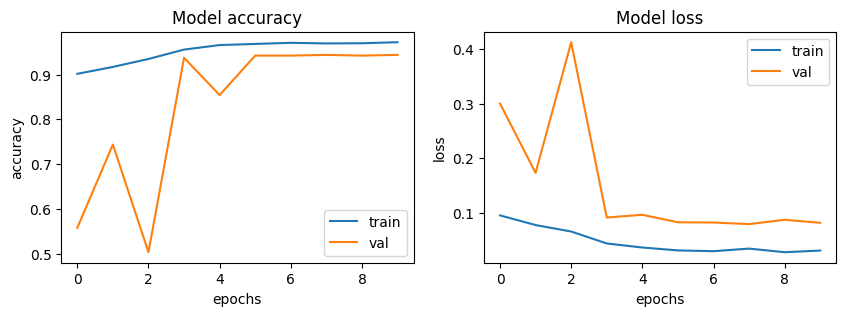

In [32]:
fig, ax = plt.subplots(1, 2, figsize=(10, 3))
ax = ax.ravel()

for i, met in enumerate(['accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [36]:
from sklearn.metrics import accuracy_score, confusion_matrix

preds = model.predict(test_data)

acc = accuracy_score(test_labels, np.round(preds))*100
cm = confusion_matrix(test_labels, np.round(preds))
tn, fp, fn, tp = cm.ravel()

print('CONFUSION MATRIX ------------------')
print(cm)

print('\nTEST METRICS ----------------------')
precision = tp/(tp+fp)*100
recall = tp/(tp+fn)*100
print('Accuracy: {}%'.format(acc))
print('Precision: {}%'.format(precision))
print('Recall: {}%'.format(recall))
print('F1-score: {}'.format(2*precision*recall/(precision+recall)))

print('\nTRAIN METRIC ----------------------')
print('Train acc: {}'.format(np.round((history.history['accuracy'][-1])*100, 2)))

20/20 [==============================] - 19s 948ms/step
CONFUSION MATRIX ------------------
[[212  22]
 [ 11 379]]

TEST METRICS ----------------------
Accuracy: 94.71153846153845%
Precision: 94.51371571072319%
Recall: 97.17948717948718%
F1-score: 95.82806573957016

TRAIN METRIC ----------------------
Train acc: 97.22
